# Statistical analysis of positional biases in gene expression responses to ascr#10

In the previous section, we could see some clumping. In this section, we re-do the analysis, with a little bit more rigor. First, we will formally test whether there are more genes changing expression than expected per chromosome (or fewer), then we will test whether genes in any given chromosome are closer together than expected by random chance, and finally we will calculate a running window correlation to figure out if any genes are more correlated than, you guessed it, expected by chance.

In [15]:
import sys
sys.path.append('../python')
import genomic_position_utils as gp
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 25, 
      'axes.titlesize': 25, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
mpl.rcParams['legend.fontsize'] = 20 

res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)

cat_type = pd.CategoricalDtype(categories=['I', 'II', 'III', 'IV', 'V', 'X'], ordered=True)
res['chromosome'] = res.chromosome.astype(cat_type)

# Genomic Location

In the next snippet, I test whether the DEGs altered at 50 AND 58hrs are enriched/depleted in any given chromosome. 

In [17]:
AND = (res['padj-58'] < 0.05) & (res['padj-50'] < 0.05) 
OR = (res['padj-58'] < 0.05) & (res['padj-50'] < 0.05)

print('DE genes at 58hrs AND at 50hrs', AND.sum())

print('\nChrom, Depleted p-value')
print('-----------------------')
# cols = ','.split('Chromosome,No. Genes in Chromosome,Observed,Bonferroni Adjusted P-value')
chrom_enrich = []
for n, g in res.groupby('chromosome'):
    Total = len(res)
    Chrom = len(g)
    draws = AND.sum()  # total number of DEGs considered
    obs = (AND & (res.chromosome == n)).sum()  # number of DEGS seen in THIS chromosome
    pval = scipy.stats.hypergeom.sf(obs, Total, Chrom, draws)
    dep = scipy.stats.hypergeom.cdf(obs, Total, Chrom, draws)
    print(n, dep)
    chrom_enrich += [[n, Chrom, obs, '{0:.2g}'.format(np.min([pval * res.chromosome.nunique(), 1]))]]

chrom_enrich = pd.DataFrame(chrom_enrich,
                            columns=['Chromosome', 'Genes in Chromosome', 'DEGs in Chromosome', 'pval'])
chrom_enrich.pval = chrom_enrich.pval.astype(np.float)
sig_chromosomes = chrom_enrich[chrom_enrich.pval < 10 ** -2].Chromosome.values

print('\n\nEnriched chromosomes')
chrom_enrich[chrom_enrich.pval < 10 ** -2].head()

DE genes at 58hrs AND at 50hrs 741

Chrom, Depleted p-value
-----------------------
I 0.9764023134104046
II 0.11441020757011652
III 0.8988993214473862
IV 0.9998904151886474
V 0.5206848322129967
X 2.2172381635649186e-08


Enriched chromosomes


,Chromosome,Genes in Chromosome,DEGs in Chromosome,pval
3,IV,2015,159,0.00066


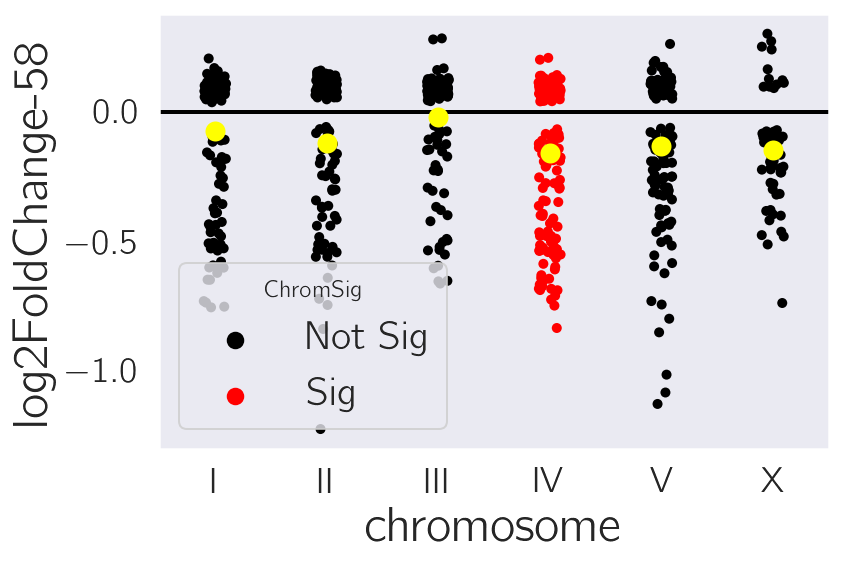

In [4]:
def save(x):
    plt.savefig('../figs/' + x, bbox_inches='tight')

res['ChromSig'] = res.chromosome.map({c: ('Not Sig' if c not in sig_chromosomes else 'Sig') for c in res.chromosome.unique()})
sns.stripplot(x='chromosome', y='log2FoldChange-58', data=res[AND],
              hue='ChromSig', palette=['black', 'red'], hue_order=['Not Sig', 'Sig'])
sns.stripplot(x='chromosome', y='log2FoldChange-58', data=res[AND].groupby('chromosome')['log2FoldChange-58'].apply(np.mean).reset_index(),
             size=10, color='yellow', jitter=False)
plt.axhline(0, color='black')
save('chrom_expression.pdf')

## Testing inter-genic distance

Next, we implement a bootstrap method to test intergenic distance. Briefly, for each chromosome, we pick, at random, the same number of genes as were differentially expressed, and compute the median distance under this random distribution. Then, we compute the fraction of simulations that had a median distance less than or equal to the observed distance. That fraction is our p-value. 

In [5]:
stat = np.median

def bootstrap(stat=np.median):
    new = res.sample(n=AND.sum(), replace=False).copy()
    new['Diff'] = np.log10(new.sort_values(['chromosome', 'startposition']
                                          ).groupby('chromosome').startposition.diff() + 1)
    return new.groupby('chromosome').Diff.median().reset_index()

boots = []
for i in range(10 ** 4):
    if i % 10 **3 == 0:
        print('Bootstrap', i, 'finished')
    boots += [bootstrap()]

boots = pd.concat(boots)

Bootstrap 0 finished
Bootstrap 1000 finished
Bootstrap 2000 finished
Bootstrap 3000 finished
Bootstrap 4000 finished
Bootstrap 5000 finished
Bootstrap 6000 finished
Bootstrap 7000 finished
Bootstrap 8000 finished
Bootstrap 9000 finished


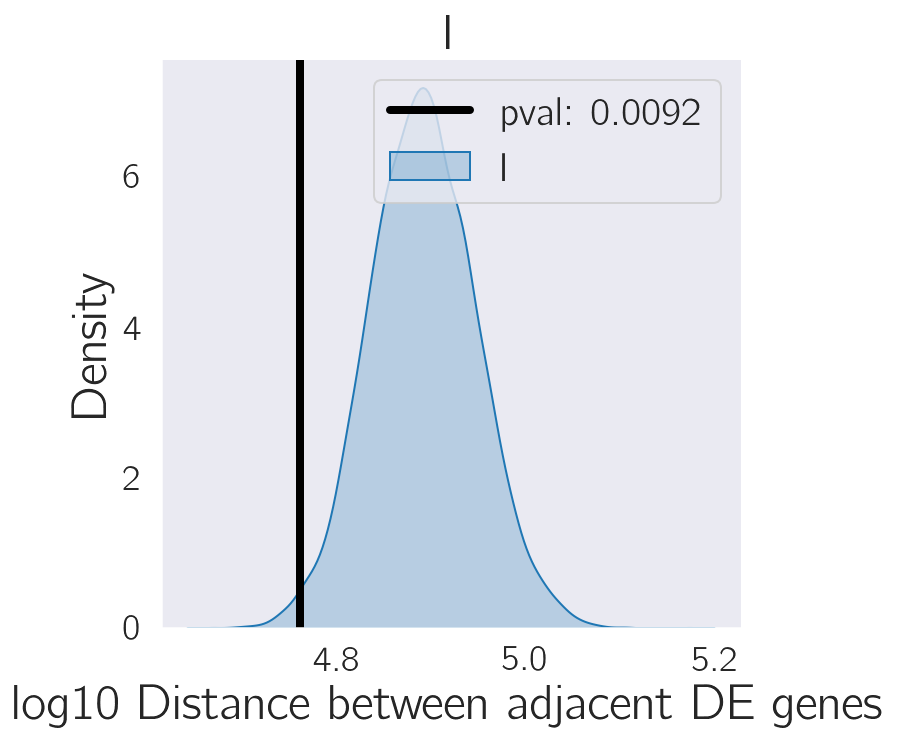

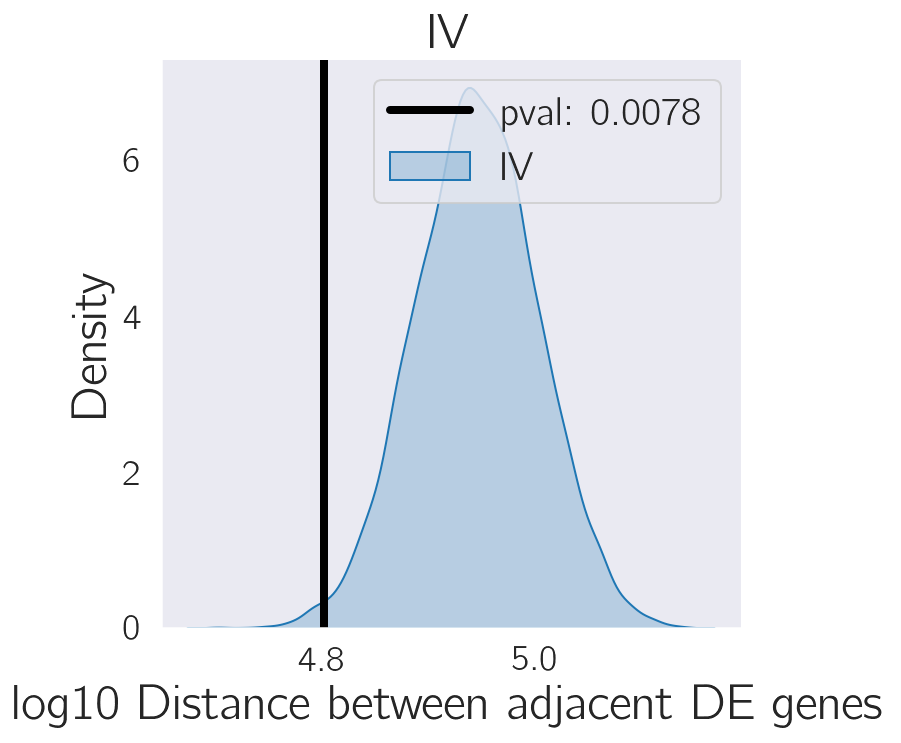

In [6]:
tmp = res[AND].copy()
tmp['Diff'] = np.log10(tmp.sort_values(['chromosome', 'startposition']).groupby('chromosome').startposition.diff() + 1)

for n, g in boots.groupby('chromosome'):
    obs = tmp[(tmp.chromosome == n)].Diff.median()
    pval = (g.Diff < obs).sum() / len(g)
    alpha = 0.05  # bonferroni correction

    if pval > alpha:
        continue

    sns.displot(g.Diff, label=n, kind='kde', fill=True)
    plt.axvline(obs, label='pval: {0:.2g}'.format(pval), lw=4, color='black')
    plt.legend()
    plt.xlabel('log10 Distance between adjacent DE genes')
    plt.title(n)

We performed 10,000 simulations in total. This means, that at best we can estimate values larger than 0.001.

# Running window correlation

Next, we compute a running window correlation by taking sequential and overlapping windows of 20 genes (ordered along the chromosomes) and computing their correlation coefficient. For each window, we plot the point at the mean position of the 20 genes. To determine whether the correlation is statistically significant or not, we shuffle the order of all the genes, and compute the windows again. We repeat this procedure many times, and from this we compute a 95% confidence interval (gray box).

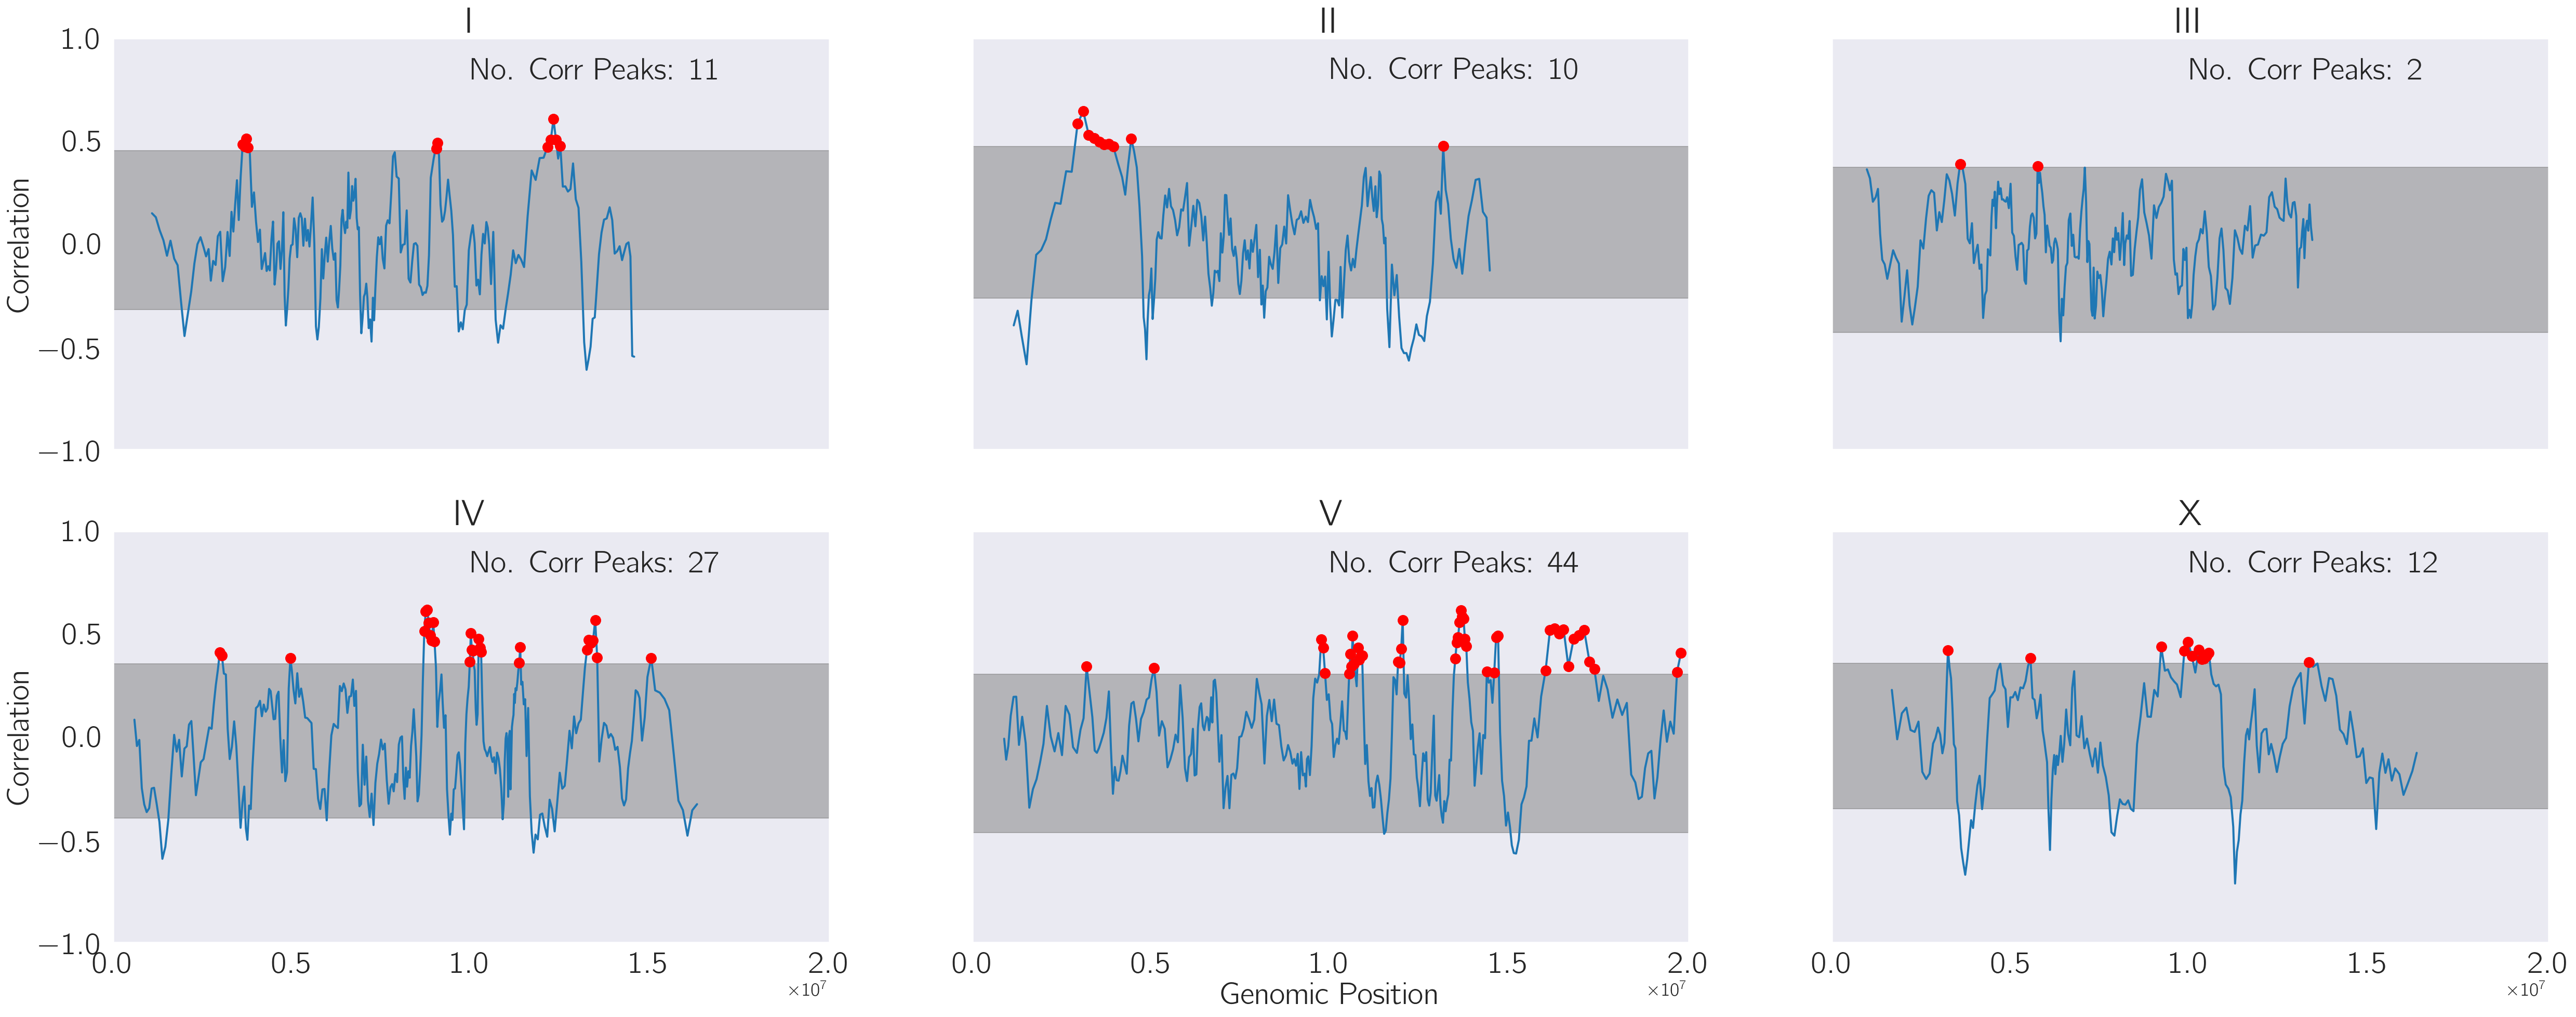

In [7]:
corr, shuffled = gp.get_corr_and_shuffle(res, x='50', pval = 0.05, window=20)

fig, ax = gp.plot_corrs(corr, shuffled)
plt.ylim(-1, 1)
save('chromosome_location_sliding_window_at_50hrs.pdf')

We have more detection power at 58hrs, so let's look at the correlations in this timepoint.

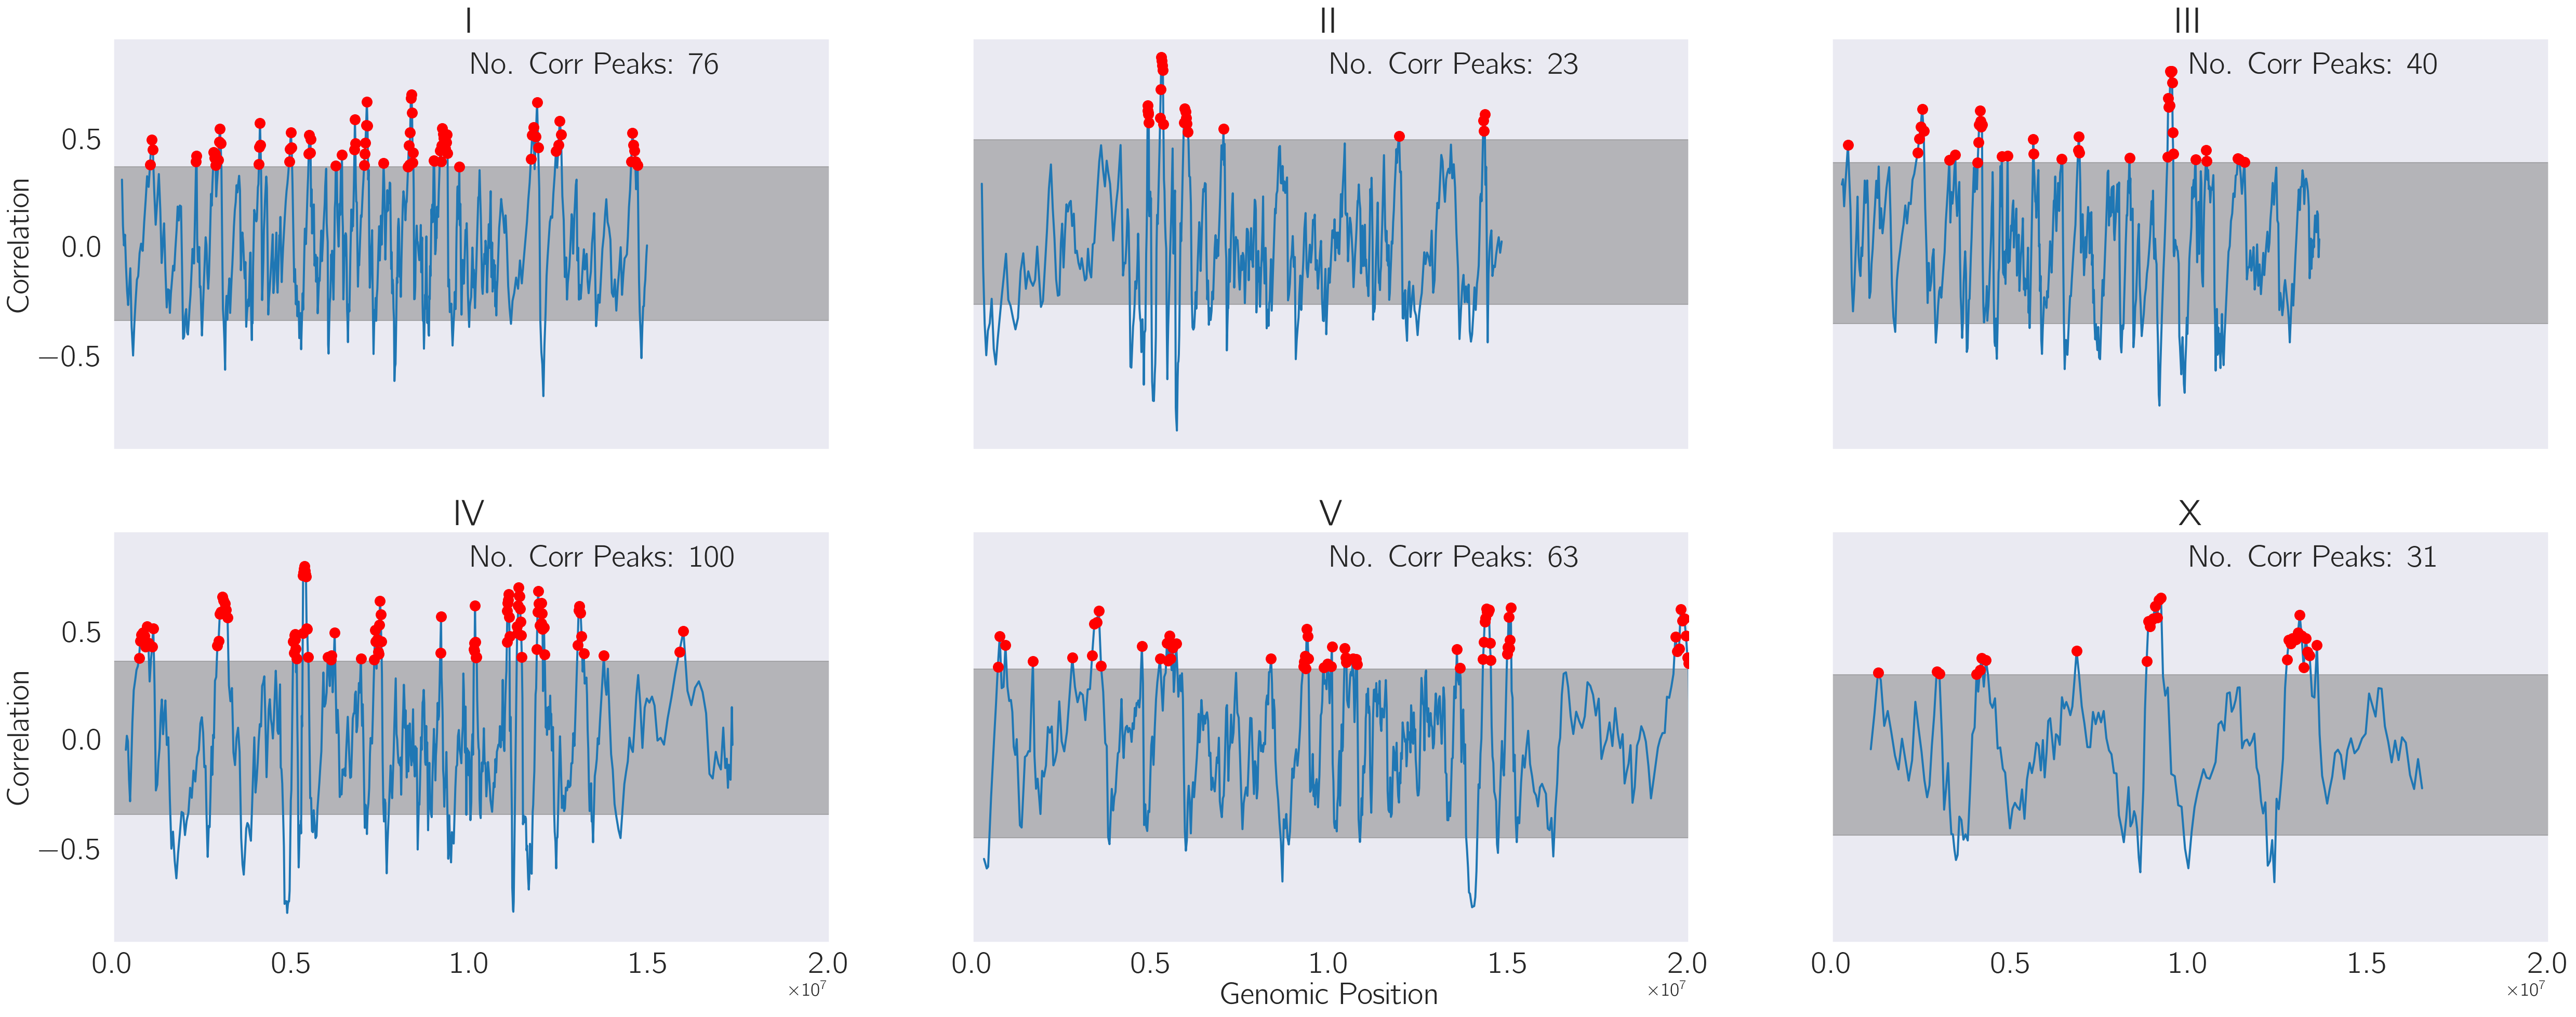

In [8]:
corr, shuffled = gp.get_corr_and_shuffle(res, '58', 0.05, window=20)
fig, ax = gp.plot_corrs(corr, shuffled)
save('chromosome_location_sliding_window_at_58hrs.svg')

# PQM-1 Enrichment

The above plots are suggestive of at least some enhancer activity. While looking through the list of ascr#10 responsive genes, one of us (IR) noticed that several had been described as PQM-1-responsive. Therefore, we used the (Tepper et al, 2013) dataset to test formally for PQM-1-responsive gene enrichment. The tests are below.

In [10]:
message, antimessage, params = gp.calculate_enrichment(res)
print('Enrichment of PQM-1 targets in commonly DE genes across 50 and 58hrs:')
print(message.format(*params))
print('Depletion of PQM-1 targets in commonly DE genes across 50 and 58hrs:')
print(antimessage.format(*params))

Enrichment of PQM-1 targets in commonly DE genes across 50 and 58hrs:
P-value associated with observing 192 class `Y` genes out of 2461 possible class 2 genes in this dataset, given 635 draws: 2.5e-08
Depletion of PQM-1 targets in commonly DE genes across 50 and 58hrs:
P-value associated with observing 192 class `Y` genes out of 2461 possible class 2 genes in this dataset, given 635 draws: 1


In [11]:
def test_enrichment_by_direction(test='pqm1', whale=False):
    for i in ['50', '58']:
        for j in ['DOWN', 'UP']:
            if j == 'UP':
                direction = (res['log2FoldChange-' + i] > 0)
            else:
                direction = (res['log2FoldChange-' + i] < 0)
            
            message, antimessage, params = gp.calculate_enrichment(res, (res['padj-' + i] < 0.05) & direction, alpha=0.01, suppress=True, test=test)
            print('Enrichment test for {0}-regulated genes at {1}hrs'.format(j, i))
            print(message.format(*params))
            print('#################################################\n')
            
test_enrichment_by_direction()

Enrichment test for DOWN-regulated genes at 50hrs
P-value associated with observing 100 class `Y` genes out of 2461 possible class 2 genes in this dataset, given 435 draws: 0.18
#################################################

Enrichment test for UP-regulated genes at 50hrs
P-value associated with observing 275 class `Y` genes out of 2461 possible class 2 genes in this dataset, given 714 draws: 1e-27
#################################################

Enrichment test for DOWN-regulated genes at 58hrs
P-value associated with observing 174 class `Y` genes out of 2461 possible class 2 genes in this dataset, given 871 draws: 0.84
#################################################

Enrichment test for UP-regulated genes at 58hrs
P-value associated with observing 391 class `Y` genes out of 2461 possible class 2 genes in this dataset, given 1612 draws: 0.0011
#################################################



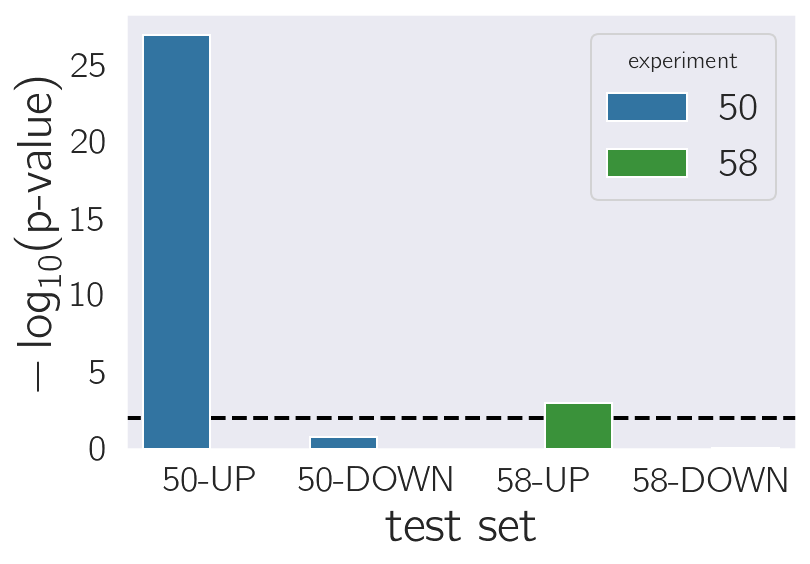

In [14]:
colors = {'58': 'tab:green', '50': 'tab:blue'}
enrichment_results = pd.DataFrame([[1 * 10 ** -27, .18, 0.0011, 0.84]],
                                  columns=['50-UP', '50-DOWN', '58-UP', '58-DOWN'], index=['p-values'])

enrichment_results = enrichment_results.melt(var_name='test set', value_name='pvalue')
enrichment_results['experiment'] = enrichment_results['test set'].str.split('-', expand=True)[0]
enrichment_results['neglogpval'] = -enrichment_results.pvalue.apply(np.log10)
sns.barplot(x="test set", y="neglogpval", data=enrichment_results, hue='experiment', palette=colors)
plt.axhline(2, ls='--', color='black', zorder=0)
plt.ylabel('$-\log_{10}($' + 'p-value' + '$)$')

plt.savefig('../figs/pvalues_pqm1.svg', bbox_inches='tight')

It appears PQM-1 responsive genes are enriched in the up-regulated genes sets at both 50 and 58 hours.